# Command Recognition using keywords

## 1. Importing Dependencies

In [28]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, regularizers, losses, optimizers
from IPython import display

### 1.1 Global Variables

In [2]:
SAMPLING_RATE = 16000 #16 kHz
DATASET_PATH = 'Data\mini_speech_commands'
SEED = 128 # A seed can be used to reproduce results // Original Value: 128
EXAMPLE_WAV = [] # Holds a batch of wav file data
EXAMPLE_FFT = [] # Holds a batch of FFT transformed data
EXAMPLE_STFT = [] # Holds a batch of STFT transformed data


### 1.2 Setting a seed

In [3]:
tf.random.set_seed(SEED)
np.random.seed(SEED)

## 2. Loading the Dataset

In [4]:
data_dir = pathlib.Path(DATASET_PATH) # Converts string to file path based on OS

# Creates the directroy and downloads dataset if not made yet
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='Data')

### 2.1 Splitting the dataset

Splits dataset into batches of audio clips with their respective integer labels

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3, # 30% used as validation/test set, will be split again later
    seed=SEED,
    output_sequence_length=16000, # Keeps all audio clips at one second
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 5600 files for training.
Using 2400 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Audio clips are in the shape of (Batch, Samples, Channels). Since there is only one channel, the channel dimension is redundant and can be eliminated

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Using tf.data.AUTOTUNE as a parameter for num_parallel_calls to dynamically adjust processing based on CPU/GPU usage
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Showing the shape of each batch

In [7]:
# 64 files each 16000 samples long per batch
for example_audio, example_labels in train_ds.take(1):
  EXAMPLE_WAV = example_audio
  print(example_audio.shape)
  print(example_labels.shape)
  print(example_labels[:10])

(64, 16000)
(64,)
tf.Tensor([7 0 4 6 4 3 0 7 1 0], shape=(10,), dtype=int32)


Split the Validation set into a seperate validation and test set, both comprising of 15% of the total dataset

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Plots waveforms of first n samples of training data

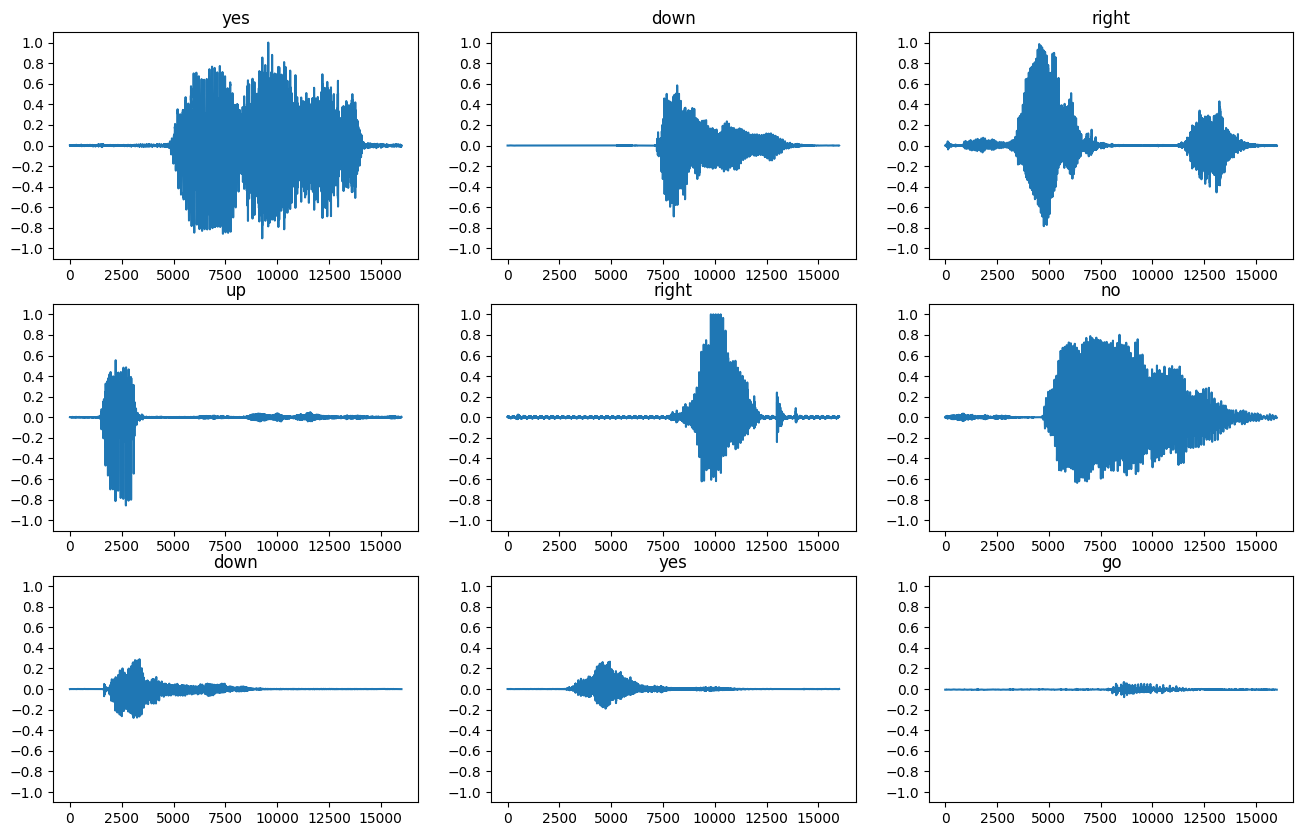

In [9]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

## 3. Processing Data

### 3.1 Visualizing Waveforms as Magnitude Spectrums

In [10]:
def FFT(audio, label):
    tf.signal.fft(tf.complex(audio, 0.0))
    return audio, label

In [11]:
train_fft = train_ds.map(FFT, tf.data.AUTOTUNE)
val_fft = val_ds.map(FFT, tf.data.AUTOTUNE)
test_fft = test_ds.map(FFT, tf.data.AUTOTUNE)

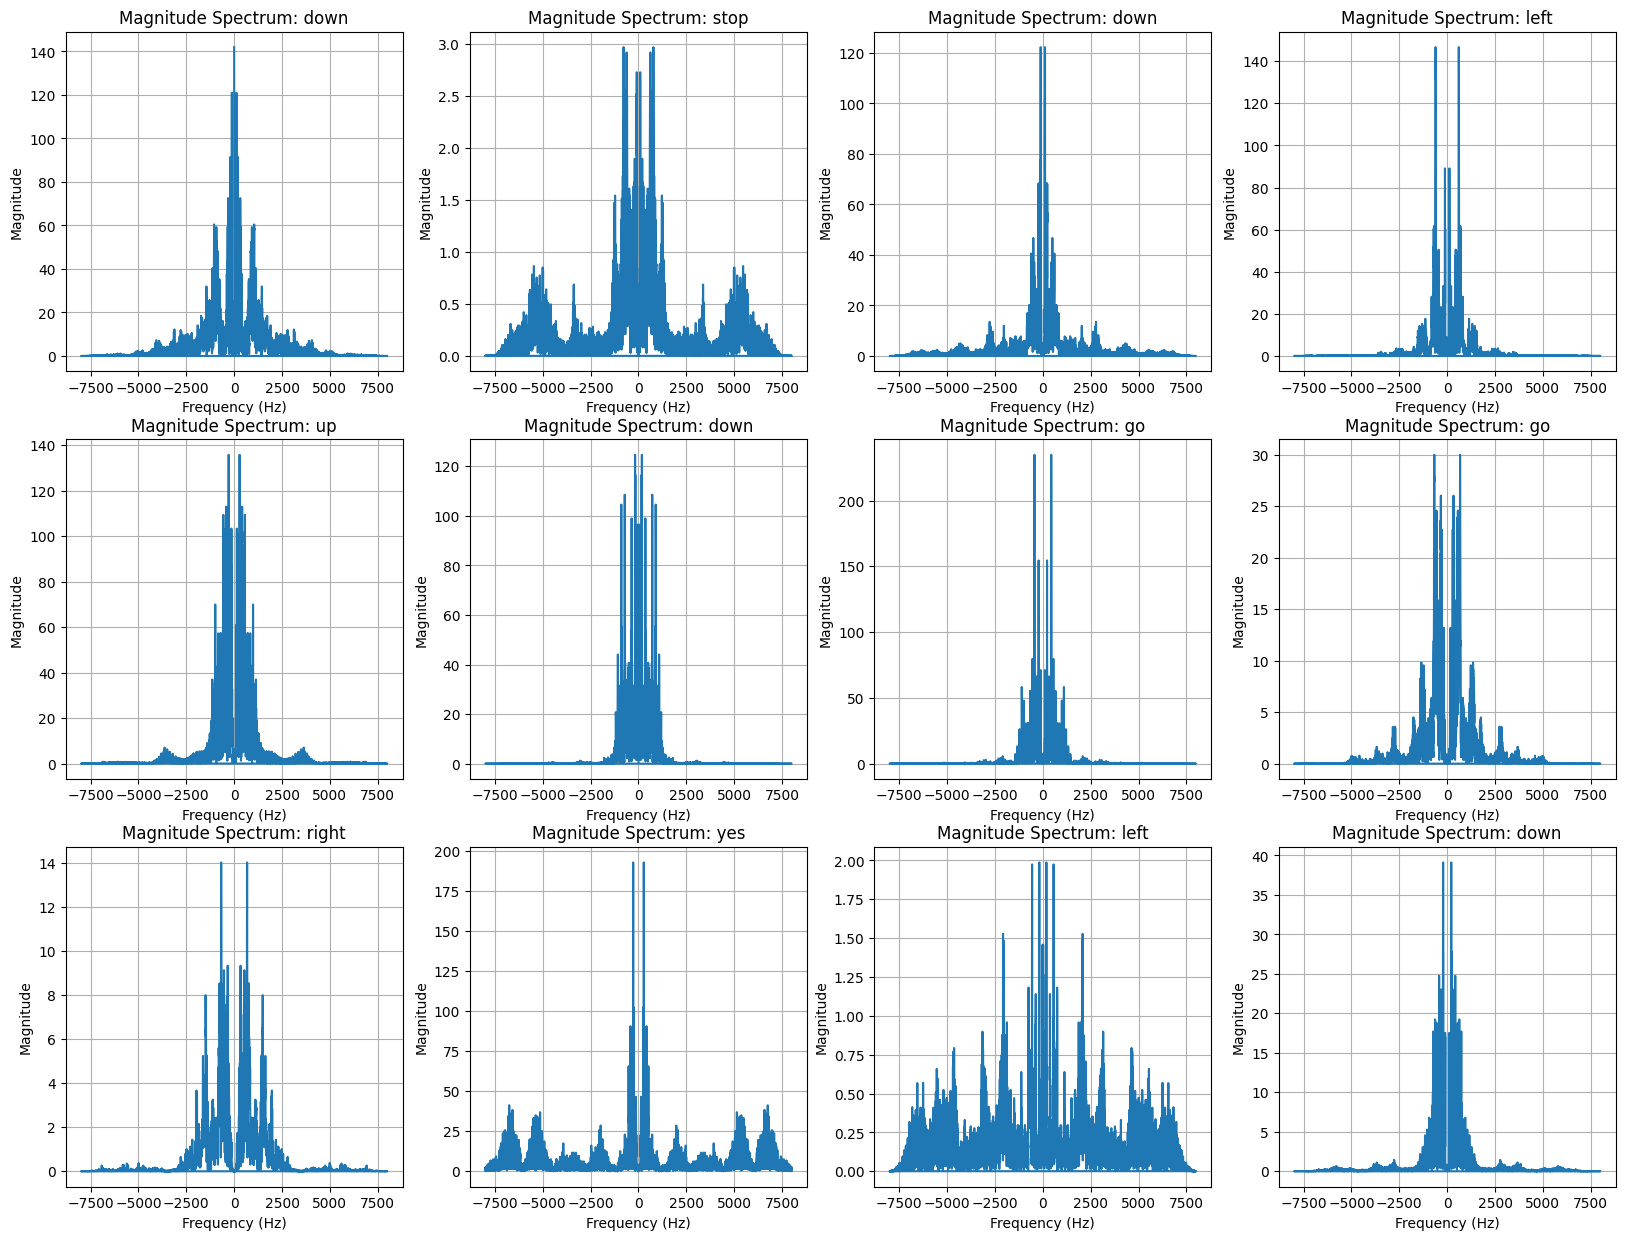

In [12]:
for example_audio, example_labels in train_fft.take(1):
    EXAMPLE_FFT = example_audio
    pass


m = 3 # Number of rows
n = 4 # Number of columns

# Create subplots
fig, axes = plt.subplots(m, n, figsize=(20, 15))

for i in range(n*m):
    # Apply FFT
    fft_output = tf.signal.fft(tf.complex(example_audio[i], 0.0))

    # Get frequency bins
    frequency_bins = np.fft.fftfreq(len(fft_output), 1 / SAMPLING_RATE)

    # Plot the spectrum (magnitude spectrum) in the corresponding subplot
    ax = axes[i // n, i % n]  # Calculate subplot index
    ax.plot(frequency_bins, np.abs(fft_output))
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'Magnitude Spectrum: {label_names[example_labels[i]]}')
    ax.grid(True)

### 3.2 Visualizing the Waveforms as Spectrograms

In [13]:
def get_spectrogram(waveform, labels):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, labels

In [14]:
train_stft = train_ds.map(get_spectrogram, tf.data.AUTOTUNE)
val_stft = val_ds.map(get_spectrogram, tf.data.AUTOTUNE)
test_stft = test_ds.map(get_spectrogram, tf.data.AUTOTUNE)

In [15]:
for example_audio, example_labels in train_ds.take(1):
  pass

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram, _ = get_spectrogram(waveform, _)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

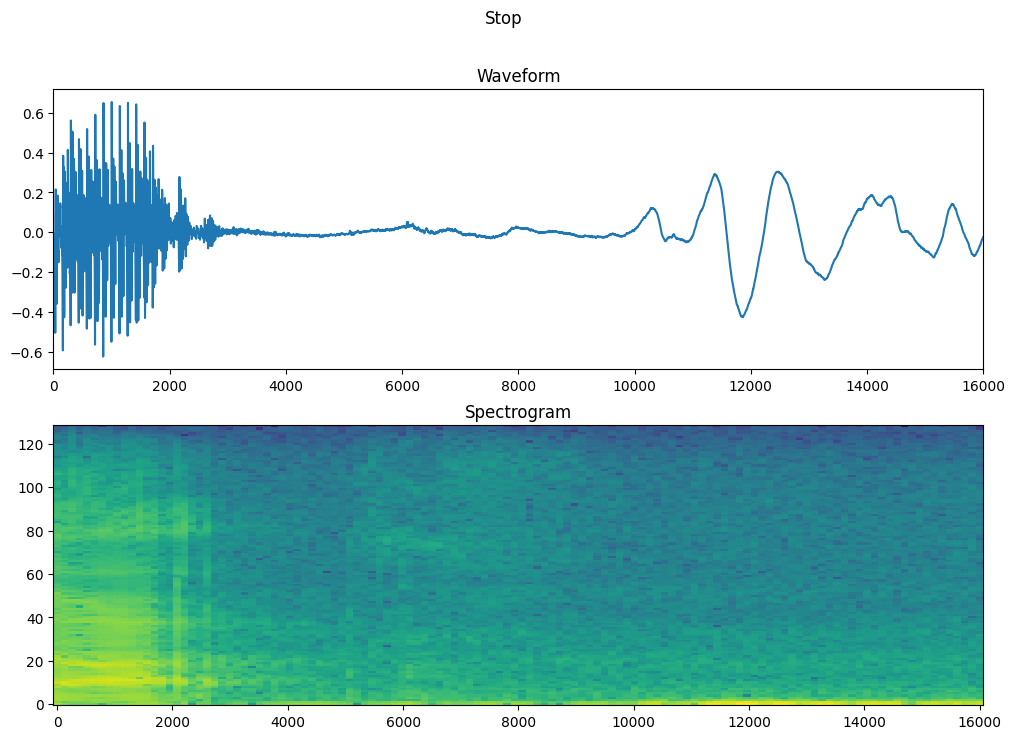

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

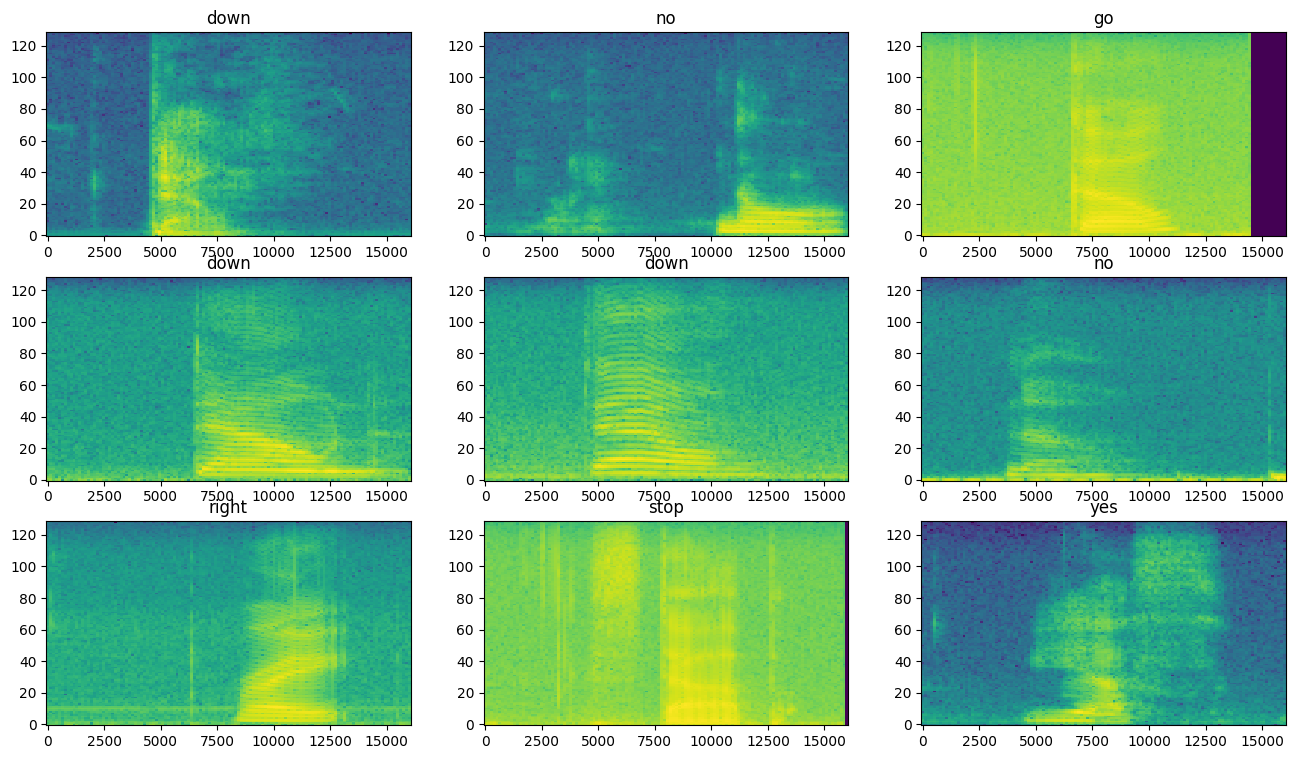

In [18]:
for example_spectrograms, example_spect_labels in train_stft.take(1):
    EXAMPLE_STFT = example_spectrograms
    pass

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

The purple blocks in the spectrogram represents the padding in the shorter clips. The spectrograms that seem to be more green are louder audio clips

## 4. Building the Models

### 4.1 Model 1: Magnitude Spectrum Input

Adding cache and prefetch operations to the datasets reduces read latency when pulling data to feed to the models

In [19]:
train_fft = train_fft.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_fft = test_fft.cache().prefetch(tf.data.AUTOTUNE)
val_fft = val_fft.cache().prefetch(tf.data.AUTOTUNE)

#### First Trial

For this model, I am going to use a Dense Neural Network

In [20]:
input_shape = EXAMPLE_FFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_fft.map(lambda fft, labels: fft)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='FFT_Model')

model.summary()


Model: "FFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

In [21]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
epochs = 100

training = model.fit(
    train_fft,
    validation_data=val_fft,
    epochs=epochs,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1278 - loss: 2.4614 - val_accuracy: 0.1436 - val_loss: 2.1464
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2374 - loss: 2.0849 - val_accuracy: 0.1343 - val_loss: 2.0911
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3056 - loss: 1.9153 - val_accuracy: 0.1385 - val_loss: 2.1533
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4006 - loss: 1.7683 - val_accuracy: 0.1394 - val_loss: 2.2423
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4780 - loss: 1.5302 - val_accuracy: 0.1402 - val_loss: 2.4282
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5438 - loss: 1.4345 - val_accuracy: 0.1478 - val_loss: 2.5158
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6011 - loss: 1.2688 - val_accuracy: 0.1495 - val_loss: 2.7169
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6577 - loss: 1.1111 - val_accuracy: 0.1436 - val_l

KeyboardInterrupt: 

#### First Trial Notes

The model performed incredibly poorly on the first attempt. I let it run for 66 epochs and the training accuracy improved from 41% to 98%, however the validation accuracy stayed at about 14% which is only slighlty better than random guessing. The validation loss increased nearly 6 fold over the course of training. Im honestly a little surpirsed by these results. Even though upon first inspection of the magnitude spectrums, words that were classified the same looked like they differed significantly from one another, I would have assumed that the magnitude spectrum of words would have underlying similarities between word of their same classification. 

#### Further Tuning

In [29]:
input_shape = EXAMPLE_FFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_fft.map(lambda fft, labels: fft)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.3),
    layers.Dense(50, activation='sigmoid', kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.5),
    layers.Dense(output_shape)
], name='FFT_Model')

model.summary()

# When using SCCE loss, keras internally converts the class labels to one hot encoded vectors
model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


epochs = 50

training = model.fit(
    train_fft,
    validation_data=val_fft,
    epochs=epochs,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Model: "FFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 16000)          │        32,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1331 - loss: 18.7947 - val_accuracy: 0.1301 - val_loss: 5.5212
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.1542 - loss: 3.9812 - val_accuracy: 0.1182 - val_loss: 2.3436
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1363 - loss: 2.3630 - val_accuracy: 0.1208 - val_loss: 2.1729
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1327 - loss: 2.2445 - val_accuracy: 0.1225 - val_loss: 2.1251
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.1266 - loss: 2.1978 - val_accuracy: 0.1166 - val_loss: 2.1163
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.1197 - loss: 2.1671 - val_accuracy: 0.1166 - val_loss: 2.1135
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.1291 - loss: 2.1518 - val_accuracy: 0.1225 - val_loss: 2.1113
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1187 - loss: 2.1707 - val_accuracy: 0.1166 - 

KeyboardInterrupt: 

After further tweaking of hyperparameters such as layer size, activation function, adding l1 and l2 regularization, and dropout rates, I have not been able to increase the performance of the model. The model seems to suffer from overfitting early on and only leans the intricate relationship of the training data that cannot be applied to unseen data. My guess is that eliminating the time aspect of the sound wav oversimplifies its data representation too much. Spoken words are a complex series of different pitches at different intensities and duration  

### 4.2 Model 2: Waveform Model

In [40]:
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [41]:
input_shape = EXAMPLE_WAV[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_ds.map(lambda wav, labels: wav)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='Wav_Model')

model.summary()

Model: "Wav_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_12                │ (None, 16000)          │        32,001 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │     4,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 8)              │           408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,011 (15.90 MB)

 Trainable params: 4,136,010 (15.78 MB)

 Non-trainable params: 32,001 (125.01 KB)

In [42]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [44]:
epochs = 20

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.2971 - loss: 1.9674 - val_accuracy: 0.1292 - val_loss: 2.1235
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3521 - loss: 1.8009 - val_accuracy: 0.1419 - val_loss: 2.2106
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4210 - loss: 1.6778 - val_accuracy: 0.1512 - val_loss: 2.3053
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4752 - loss: 1.5435 - val_accuracy: 0.1495 - val_loss: 2.4048
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5467 - loss: 1.3922 - val_accuracy: 0.1292 - val_loss: 2.5255
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6104 - loss: 1.2548 - val_accuracy: 0.1402 - val_loss: 2.8631
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6560 - loss: 1.0634 - val_accuracy: 0.1377 - val_loss: 2.9602
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6990 - loss: 0.9498 - val_accuracy: 0.1410 - v

#### Trial 1 Notes

This model does not seem to be learning at all, the validation loss and accuracy were nearly constant and the training metrics barely improved over 20 epochs. It is surprising because I feel like there is more observed similarity in the waveforms of words within the same category. 

In [48]:
input_shape = EXAMPLE_WAV[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_ds.map(lambda wav, labels: wav)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    norm_layer,
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #layers.Dropout(0.2),
    layers.Dense(output_shape)
], name='Wav_Model')

model.summary()

model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 20

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Model: "Wav_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_16                │ (None, 16000)          │        32,001 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 512)            │     8,192,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,298,953 (31.66 MB)

 Trainable params: 8,266,952 (31.54 MB)

 Non-trainable params: 32,001 (125.01 KB)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.1292 - loss: 27.0080 - val_accuracy: 0.1326 - val_loss: 7.6433
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.2928 - loss: 5.3377 - val_accuracy: 0.1292 - val_loss: 3.2408
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.2998 - loss: 3.0071 - val_accuracy: 0.1267 - val_loss: 3.1934
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.4430 - loss: 2.5335 - val_accuracy: 0.1444 - val_loss: 3.2340
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.5631 - loss: 2.2950 - val_accuracy: 0.1242 - val_loss: 3.5988
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6285 - loss: 2.0478 - val_accuracy: 0.1453 - val_loss: 3.7640
Epoch 6: early stopping


After tuning hyperparameters such as dropout rates, adding regularizers, varying layer size, and changing activation functions, I was not able to get the models performance to improve. I assume it is because the model only gains information about the intensity and duration of the signal but doesnt have enough information to learn about the frequencies that make up the signal. Since speech is so complex, all three features are needed to learn the patterns unique to each word. 

### 4.3 Model 3: Spectrogram Model using STFT

The difference between FFT and STFT is that the STFT, known as the Short Time Fourier Transform, can extract the magnitude spectrum of a signal while preserving the time data of the signal. Since the spectrogram that is produced by the STFT is a 3 dimensional representation of a sound wave, a CNN is the best model to use to process the input data.  

In [86]:
train_stft = train_stft.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_fft = test_fft.cache().prefetch(tf.data.AUTOTUNE)
val_stft = val_stft.cache().prefetch(tf.data.AUTOTUNE)

In [87]:
input_shape = EXAMPLE_STFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_stft.map(lambda spec, labels: spec)) # Uses the fft data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(128, 2, activation='relu'),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(output_shape),
], name='STFT_Model')

model.summary()

Model: "STFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_23 (Resizing)          │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 31, 31, 128)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 30, 30, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,440 (1.83 MB)

 Trainable params: 478,440 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [91]:
epochs = 10

model.fit(
    train_stft,
    validation_data=val_stft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), # Comment out for testing and analysis
)

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8166 - loss: 0.5086 - val_accuracy: 0.8226 - val_loss: 0.5325
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8251 - loss: 0.4784 - val_accuracy: 0.8260 - val_loss: 0.5372
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8286 - loss: 0.4611 - val_accuracy: 0.8285 - val_loss: 0.5242
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8592 - loss: 0.3995 - val_accuracy: 0.8269 - val_loss: 0.5171
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8645 - loss: 0.3981 - val_accuracy: 0.8429 - val_loss: 0.4905
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8722 - loss: 0.3715 - val_accuracy: 0.8302 - val_loss: 0.5118
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8691 - loss: 0.3621 - val_accuracy: 0.8421 - val_loss: 0.4727
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8757 - loss: 0.3541 - val_accuracy: 0.8480 - v

#### First Trial Notes

My first time training the model, I didn't think the resizing layer was necessary and I though maybe the accuracy would improve without it but the model took too long to compile. A resizing layer was needed to perform hyperparameter tuning and proper analysis in a feesible amount of time. After adding the resizing layer and training the model, the model performed pretty well, endeding with a training accuracy of 89% and a validation accuracy of 85%. It seems like the model is suffering from some overfitting which can be reduced by adding or tuning dropout layers, changing the complexity of the model, or adding some regularization. 

In [116]:
input_shape = EXAMPLE_STFT[0].shape
output_shape = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_stft.map(lambda spec, labels: spec)) # Uses the STFT data to set the initial state of the normalization layer

model = models.Sequential([
    layers.Input(input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.35),
    layers.Dense(output_shape),
], name='STFT_Model')

model.summary()

model.compile(
    optimizer=optimizers.Nadam(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 30

fit_data = model.fit(
    train_stft,
    validation_data=val_stft,
    epochs=epochs,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3), # Comment out for testing and analysis
)

Model: "STFT_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_47 (Resizing)          │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_67                │ (None, 32, 32, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 30, 30, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_165 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 12, 12, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,595 (1.31 MB)

 Trainable params: 343,592 (1.31 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.1698 - loss: 2.0525 - val_accuracy: 0.3691 - val_loss: 1.7807
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.3508 - loss: 1.7690 - val_accuracy: 0.5642 - val_loss: 1.2762
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.5058 - loss: 1.3307 - val_accuracy: 0.6529 - val_loss: 0.9338
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.6075 - loss: 1.0148 - val_accuracy: 0.7297 - val_loss: 0.7663
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 210ms/step - accuracy: 0.6810 - loss: 0.8488 - val_accuracy: 0.7770 - val_loss: 0.6143
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.7249 - loss: 0.7293 - val_accuracy: 0.7973 - val_loss: 0.5509
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.7532 - loss: 0.6435 - val_accuracy: 0.8041 - val_loss: 0.5103
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.7742 - loss: 0.6034 - val_accu

Best changes made were adding a second dropout layer, adding upsampling before the max pooling layer, and changing the size of the layers. Adding another dense layer also seemed to improve accuracy with validation accuracy reaching 83.19%. I tried adding two more convolutional layers, 16 and 32 neurons, along with a maxpooling layer and it seemed to decrease the accuracy by a significant margin which I was a little surprised about, I guess it downsampled the data too much where it lost some important features. Doubling the neuron count in all the convolution layers and letting the model run for a little longer, I was able to increase the validation accuracy to 88.51% with a training accuracy of 90.12% which means there isnt much overfitting. I noticed that the loss of the model started relatively high so I tried adding glorot normal kernel initializers to the convolutional and dense layers but it seemed to have little or no affect, with both losses during testing starting at around 2. I also tried editing the kernel size of the maxpooling layer, increasing it to 3x3, but it only had negative effects on the models performance. I also changed the optimizer from Adam to Nadam hopping it would help the model converge to a minimum loss faster and it seems to have a slight improvment on the models performance. The last changes I made was adding one more dropout layer before the output layer and set it to a .35 dropout rate and let the model run for a little longer while giving it a little more patience to try and maximize the models performance as much as possible. With these changes I was able to reach a traing accuracy and loss of 93.84% and 0.1852 as well as a valadation accuracy and loss of 90.37% and 0.37 after 28 epochs, which is 5% more than the base model. 

#### Observing model progression over training

Text(0, 0.5, 'Accuracy [%]')

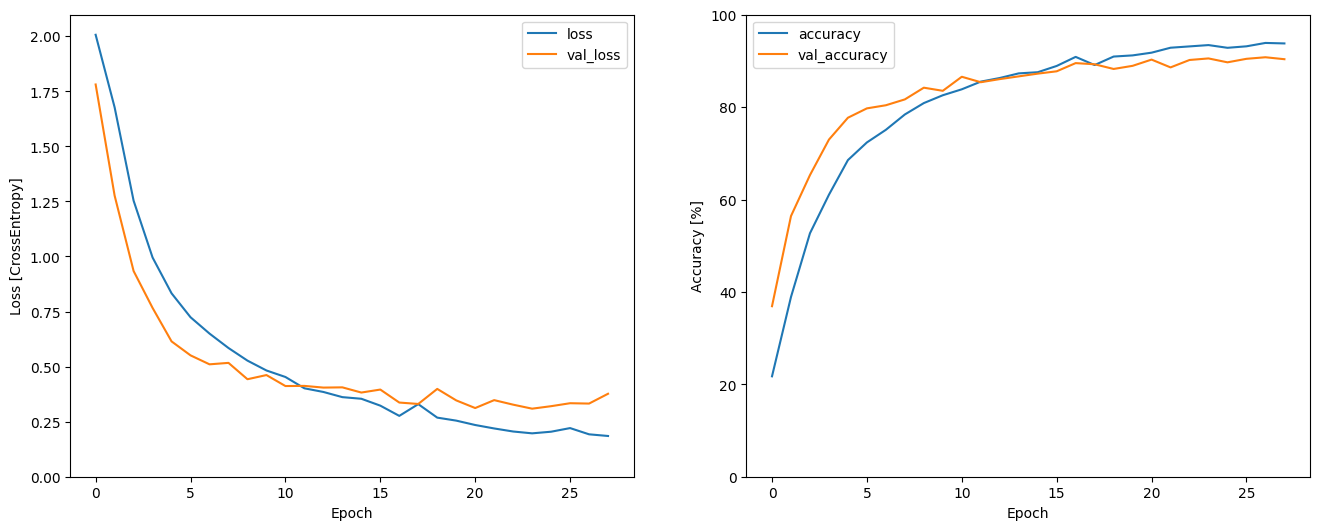

In [118]:
metrics = fit_data.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(fit_data.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(fit_data.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## 5. Evaluating performance

### 5.1 Testing model on the test data

In [121]:
model.evaluate(test_stft, return_dict=True)

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9145 - loss: 0.2511

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9036 - loss: 0.3386


{'accuracy': 0.9021381735801697, 'loss': 0.3912113606929779}

90% on the test data is all I could have hoped for. This is a pretty good result especially for this dataset where some of the clips are noisy and have similar sounding words which are used to increase the robustness of the model.

### 5.2 Displaying the Confusion Matrix

In [122]:
y_pred = model.predict(test_stft)

y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_stft.map(lambda s,lab: lab)), axis=0)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


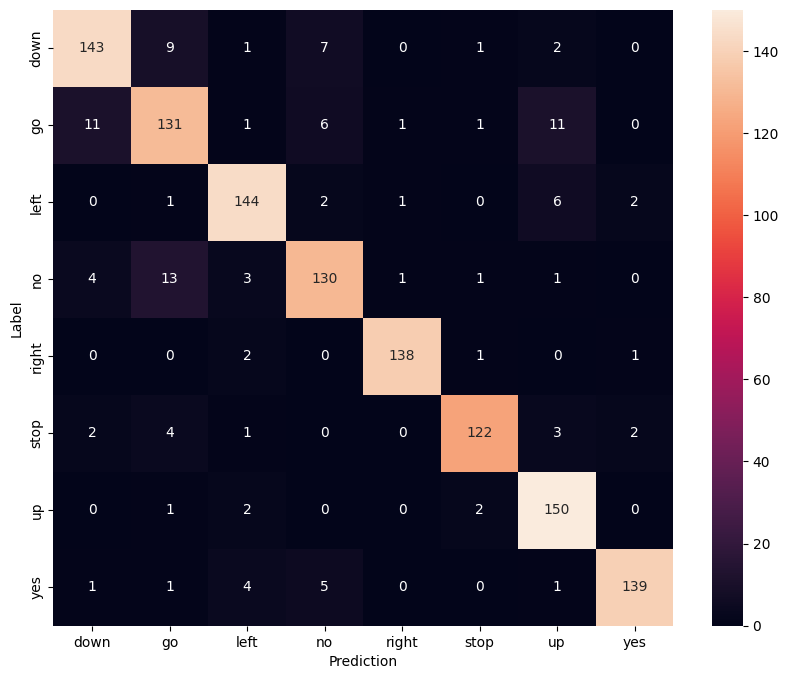

In [123]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

"Go" and "No" seem to be the hardest words for the model to accurately predict

### 5.3 Running Inference on an audio file

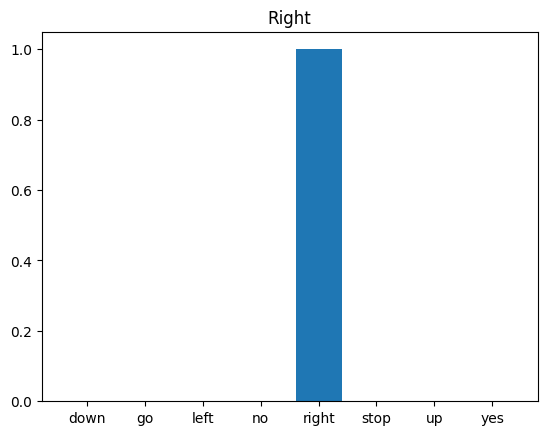

In [132]:
x = data_dir/'right/fce65496_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLING_RATE,)
x = tf.squeeze(x, axis=-1)
waveform = x
x, _ = get_spectrogram(x, _)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Right')
plt.show()

display.display(display.Audio(waveform, rate=16000))

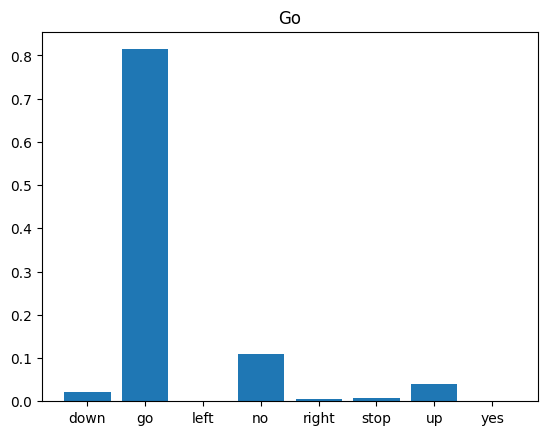

In [131]:
x = data_dir/'go/0d53e045_nohash_0.wav'  #'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=SAMPLING_RATE,)
x = tf.squeeze(x, axis=-1)
waveform = x
x, _ = get_spectrogram(x, _)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Go')
plt.show()

display.display(display.Audio(waveform, rate=16000))

This shows the difference in uncertainty the model has with the words "Right", which the model nearly got 100% of classifications for right according to the confusion matrix, and "Go", which the model missclasified quite a bit.

### 5.4 Exporting the model

In [141]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x, _ = get_spectrogram(x, None)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [144]:
'''
# Commented out to avoid overwriting saved model
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))
tf.saved_model.save(export, "saved")
'''


'\n# Commented out to avoid overwriting saved model\nexport = ExportModel(model)\nexport(tf.constant(str(data_dir/\'no/01bb6a2a_nohash_0.wav\')))\ntf.saved_model.save(export, "saved")\n'

In [145]:
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ -2.8964682,  -3.5207653,   7.2333927,  -1.3989667,  21.12706  ,
         -13.1266985, -12.497387 ,  -5.2514076]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}